# CP24_DanTrezise_FinalReport

#### NOTES:
1. This notebook is reduced to just the final workflow that produced the best results.
2. Originally I hoped to merge 5 datasets to acheive better results but in the end better results came from only using one dataset
3. I tried multiple models. The 4 remaining in this notebook are the only ones that produced interesting results
4. Scaling the data or not and which scaler to use had significant impact on the results of the various models
    
    


# Libraries

In [1]:
# Import all necessary libraries
# python base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

# visualization tools
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# models
from sklearn import tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline

# model tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## df_bis: Best in Show dataset

In [2]:
# Dog df for Best in Show
# The loaded data below is a reduced version of ../data/best_in_show.csv
# It was more efficient to reorganize, label and reduce the dataset in excel as a starting point

# Load dataset and review shape

df_bis = pd.read_csv('../data/best_in_show_reduced.csv')

### Data Overview

In [3]:
# Overview of columns

df_bis.columns, df_bis.shape

(Index(['Popularity ', 'Breed', 'Group', 'Size', 'Price Bracket', 'Price low',
        'Price high', 'Lifetime Cost', 'Lifespan', 'Genetic Ailments',
        'Grooming Score', 'Intelligence Category', 'Trainability',
        'Training Repetitions', 'Odedience', 'Children Score'],
       dtype='object'),
 (172, 16))

In [4]:
df_bis.sample(5)

,Popularity,Breed,Group,Size,Price Bracket,Price low,Price high,Lifetime Cost,Lifespan,Genetic Ailments,Grooming Score,Intelligence Category,Trainability,Training Repetitions,Odedience,Children Score
3,47,Akita,working,large,mid-price,565,1800,"20,994",10.16,1.0,2,Average,54.0,25 to 40,50,3
14,93,Basenji,hound,medium,mid-price,600,1200,"22,096",13.58,3.0,2,Lowest,79.0,80 to 100,<25,2
110,110,Neapolitan Mastiff,working,large,high-end,850,3500,NaN,NaN,1.0,2,NaN,NaN,NaN,NaN,1
118,84,Old English Sheepdog,herding,medium,mid-price,500,1000,"22,611",11.19,1.0,1,Fair,63.0,40 to 80,30,1
141,105,Schipperke,non-sporting,small,budget,300,975,NaN,13,4.0,-,Excellent,15.0,5 to 15,85,-


In [5]:
df_bis.describe()

,Popularity,Genetic Ailments,Trainability
count,172.000000,148.000000,132.000000
mean,87.122093,1.216216,40.924242
std,50.205335,1.549810,19.603560
min,1.000000,0.000000,1.000000
25%,43.750000,0.000000,27.000000
50%,87.500000,1.000000,42.000000
75%,130.250000,2.000000,54.250000
max,173.000000,9.000000,80.000000


### Data Clean Up

In [6]:
df_bis.isnull().sum()

Popularity                0
Breed                     0
Group                     0
Size                      0
Price Bracket            26
Price low                26
Price high               26
Lifetime Cost            81
Lifespan                 36
Genetic Ailments         24
Grooming Score            0
Intelligence Category    40
Trainability             40
Training Repetitions     40
Odedience                40
Children Score            0
dtype: int64

In [7]:
# Dropping columns with lots of null values or limited impact on the model

df_bis.drop("Lifetime Cost", axis=1,inplace=True)
df_bis.drop("Price low", axis=1,inplace=True)
df_bis.drop("Price high", axis=1,inplace=True)
df_bis.drop("Trainability", axis=1,inplace=True)
df_bis.drop("Training Repetitions", axis=1,inplace=True)
df_bis.drop("Odedience", axis=1,inplace=True)
df_bis.drop("Grooming Score", axis=1,inplace=True)
df_bis.drop("Children Score", axis=1,inplace=True)

df_bis.dropna(axis=0, inplace=True)
df_bis.isnull().sum()

Popularity               0
Breed                    0
Group                    0
Size                     0
Price Bracket            0
Lifespan                 0
Genetic Ailments         0
Intelligence Category    0
dtype: int64

In [8]:
df_bis.shape

(103, 8)

In [9]:
# Overview of df

df_bis.head()

,Popularity,Breed,Group,Size,Price Bracket,Lifespan,Genetic Ailments,Intelligence Category
0,139,Affenpinscher,toy,small,budget,11.42,0.0,Above average
1,88,Afghan Hound,hound,large,mid-price,11.92,0.0,Lowest
2,55,Airedale Terrier,terrier,medium,mid-price,11.45,1.0,Above average
3,47,Akita,working,large,mid-price,10.16,1.0,Average
4,58,Alaskan Malamute,working,large,mid-price,10.67,2.0,Average


In [10]:
# df_bis['Genetic Ailments'].unique()

In [11]:
# Converting strings to useful number rankings
# I had to cast objects to str before using .str.replace

df_bis['Size'] = df_bis['Size']\
    .astype(str).str.replace('small', '0')\
    .astype(str).str.replace('medium', '.5')\
    .astype(str).str.replace('large', '1')

df_bis['Price Bracket'] = df_bis['Price Bracket']\
    .astype(str).str.replace('budget', '0')\
    .astype(str).str.replace('mid-price', '.5')\
    .astype(str).str.replace('high-end', '1')

df_bis['Intelligence Category'] = df_bis['Intelligence Category']\
    .astype(str).str.replace('Lowest', '0')\
    .astype(str).str.replace('Fair', '.25')\
    .astype(str).str.replace('Average', '.5')\
    .astype(str).str.replace('Above average', '.65')\
    .astype(str).str.replace('Excellent', '.85')\
    .astype(str).str.replace('Brightest', '1')

# confirm name changes
df_bis.head()

,Popularity,Breed,Group,Size,Price Bracket,Lifespan,Genetic Ailments,Intelligence Category
0,139,Affenpinscher,toy,0,0,11.42,0.0,.65
1,88,Afghan Hound,hound,1,.5,11.92,0.0,0
2,55,Airedale Terrier,terrier,.5,.5,11.45,1.0,.65
3,47,Akita,working,1,.5,10.16,1.0,.5
4,58,Alaskan Malamute,working,1,.5,10.67,2.0,.5


In [12]:
# Identify which datatypes need to be fixed
df_bis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 0 to 171
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Popularity             103 non-null    int64  
 1   Breed                  103 non-null    object 
 2   Group                  103 non-null    object 
 3   Size                   103 non-null    object 
 4   Price Bracket          103 non-null    object 
 5   Lifespan               103 non-null    object 
 6   Genetic Ailments       103 non-null    float64
 7   Intelligence Category  103 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 7.2+ KB


In [13]:
# Converting datatypes & confirm...

df_bis[['Size', 'Price Bracket', 'Lifespan', 'Intelligence Category']] = df_bis[['Size', 'Price Bracket', 'Lifespan', 'Intelligence Category']].astype(float)
df_bis.info()

# Looks great!

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 0 to 171
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Popularity             103 non-null    int64  
 1   Breed                  103 non-null    object 
 2   Group                  103 non-null    object 
 3   Size                   103 non-null    float64
 4   Price Bracket          103 non-null    float64
 5   Lifespan               103 non-null    float64
 6   Genetic Ailments       103 non-null    float64
 7   Intelligence Category  103 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 7.2+ KB


In [14]:
df_bis.isnull().sum()

Popularity               0
Breed                    0
Group                    0
Size                     0
Price Bracket            0
Lifespan                 0
Genetic Ailments         0
Intelligence Category    0
dtype: int64

In [15]:
# look at df for any obvious remaining issues

df_bis.head()

# Looks ready to use

,Popularity,Breed,Group,Size,Price Bracket,Lifespan,Genetic Ailments,Intelligence Category
0,139,Affenpinscher,toy,0.0,0.0,11.42,0.0,0.65
1,88,Afghan Hound,hound,1.0,0.5,11.92,0.0,0.00
2,55,Airedale Terrier,terrier,0.5,0.5,11.45,1.0,0.65
3,47,Akita,working,1.0,0.5,10.16,1.0,0.50
4,58,Alaskan Malamute,working,1.0,0.5,10.67,2.0,0.50


In [16]:
# Renaming "Popularity" to remove a space at the end
df_bis.rename(columns={'Popularity ' : 'Popularity'}, inplace=True)

### Visualizatons

<Axes: >

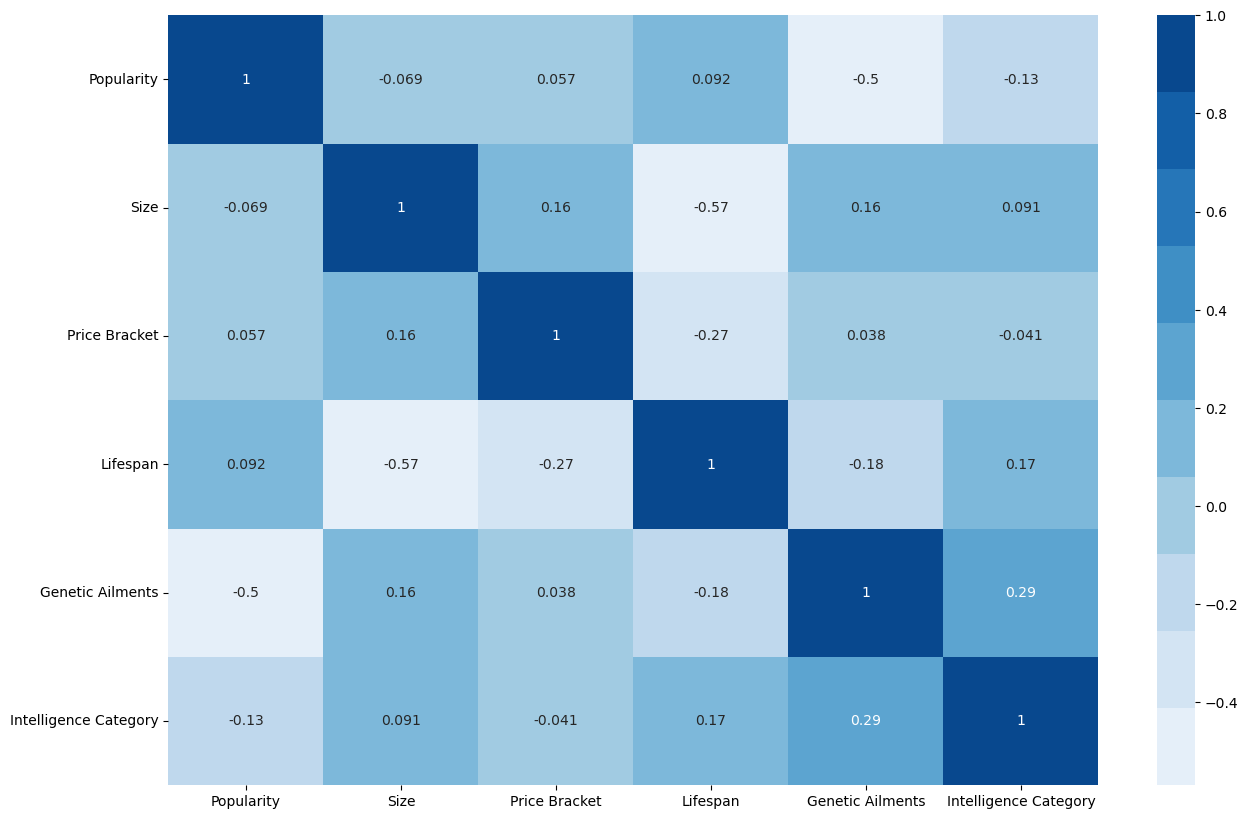

In [17]:
# A Quick Heatmap to get a visual of how features are correlating with each other

correlation = df_bis.corr(numeric_only=True)
colormap = sns.color_palette("Blues",10)
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(correlation, cmap=colormap, robust=True, annot=True)
# plt.savefig('../plots/df_bis_heatmap.png')

In [18]:
df_bis.shape

(103, 8)

## Preparing Data for Modeling

In [19]:
# Remaming to data for ease of use in modeling below
# I ended up choosing to use the "df_bis" dataset by itself, which produced better results

data = df_bis
data.columns

Index(['Popularity', 'Breed', 'Group', 'Size', 'Price Bracket', 'Lifespan',
       'Genetic Ailments', 'Intelligence Category'],
      dtype='object')

In [20]:
# feature selection

X_features = ['Popularity', 'Size', 'Price Bracket', 
            'Lifespan', 'Genetic Ailments', 'Intelligence Category']


### Scaling Features

In [21]:
# Scale features through various scalers:
# Review current scale of data

# data[X_features].head()

In [22]:
#StandardScaler
stnd_sclr = StandardScaler().fit_transform(data[X_features])
stnd_data = pd.DataFrame(stnd_sclr, columns=[X_features])

# MinMaxScaler
minmax_sclr = MinMaxScaler().fit_transform(data[X_features])
minmax_data = pd.DataFrame(minmax_sclr, columns=[X_features])

# RobustScaler
robust_sclr = RobustScaler().fit_transform(data[X_features])
robust_data = pd.DataFrame(robust_sclr, columns=[X_features])

# Normalizer
norm_sclr = Normalizer().fit_transform(data[X_features])
norm_data = pd.DataFrame(norm_sclr, columns=[X_features])

### Scaling Visualizations

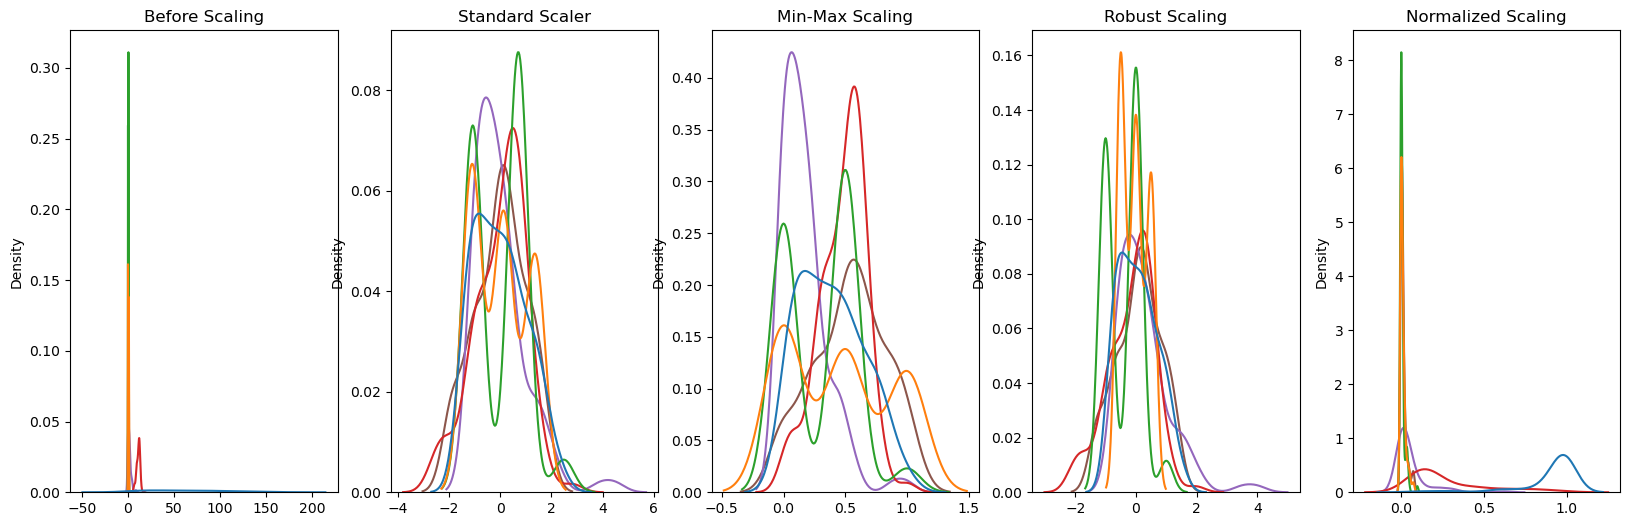

In [23]:
# Visualization of various scaling techniques on entire dataset

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(20, 6))

ax1.set_title('Before Scaling')
sns.kdeplot(data=data[X_features], ax=ax1)
ax1.get_legend().set_visible(False)

ax2.set_title('Standard Scaler')
sns.kdeplot(data=stnd_data, ax=ax2)
ax2.get_legend().set_visible(False)

ax3.set_title('Min-Max Scaling')
sns.kdeplot(data=minmax_data, ax=ax3)
ax3.get_legend().set_visible(False)

ax4.set_title('Robust Scaling')
sns.kdeplot(data=robust_data, ax=ax4)
ax4.get_legend().set_visible(False)

ax5.set_title('Normalized Scaling')
sns.kdeplot(data=norm_data, ax=ax5)
ax5.get_legend().set_visible(False)

plt.show()

## MODELING:

### Setup

#### CHOOSING WHICH SCALED DATA TO USE

In [24]:
# Define X,y with chosen scaled data

model_data = norm_data


X = model_data[X_features].drop(columns=['Popularity'])
# y = model_data['Popularity'].squeeze()
y = data['Popularity']

C:\Users\dan\AppData\Local\Temp\ipykernel_28616\861182779.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = model_data[X_features].drop(columns=['Popularity'])


### Train Test Split

In [25]:
# Train Test Split & confirm shapes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Shapes look correct

((72, 5), (31, 5), (72,), (31,))

### PCA

In [26]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]


## MODELS:

### (1) Linear Regression - multi feature (X_features)

In [27]:
# Linear Regression Model

lr = LinearRegression().fit(X_train, y_train)


In [28]:
# MODEL METRICS

# Predictions
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)

# Calculate MSES
train_mses = []
test_mses = []   
train_mses.append(mean_squared_error(y_train, train_pred))
test_mses.append(mean_squared_error(y_test, test_pred))

#Calculate other metrics
mae = mean_absolute_error(y_test, test_pred)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
rmsle = np.log(np.sqrt(mean_squared_error(y_test, test_pred)))
r2 = r2_score(y_train, train_pred)
score = lr.score(X_train, y_train)
intercept = lr.intercept_
coef = lr.coef_

# Print Metrics for Review
print('Model Metrics:', '\n')
print('Train MSE =', train_mses, '    Test MSE =', test_mses, '     MAE =', mae)
print("RMSE =", rmse, '     RMSLE =', rmsle)
print('Accuracy Score =', score, '      R2 Score =', r2, '\n') 


Model Metrics: 

Train MSE = [522.1756391823833]     Test MSE = [885.9102039672657]      MAE = 25.025996824202032
RMSE = 29.764243715694604      RMSLE = 3.3933077977723753
Accuracy Score = 0.6918272619768583       R2 Score = 0.6918272619768583 



### Best Result from trying each of the different scaled versions of the data:|

#### X,y - scaled - normalization:
        Accuracy Score = 0.8522976547707313       
        R2 Score = 0.8522976547707313

### Plotting LR results on train and test

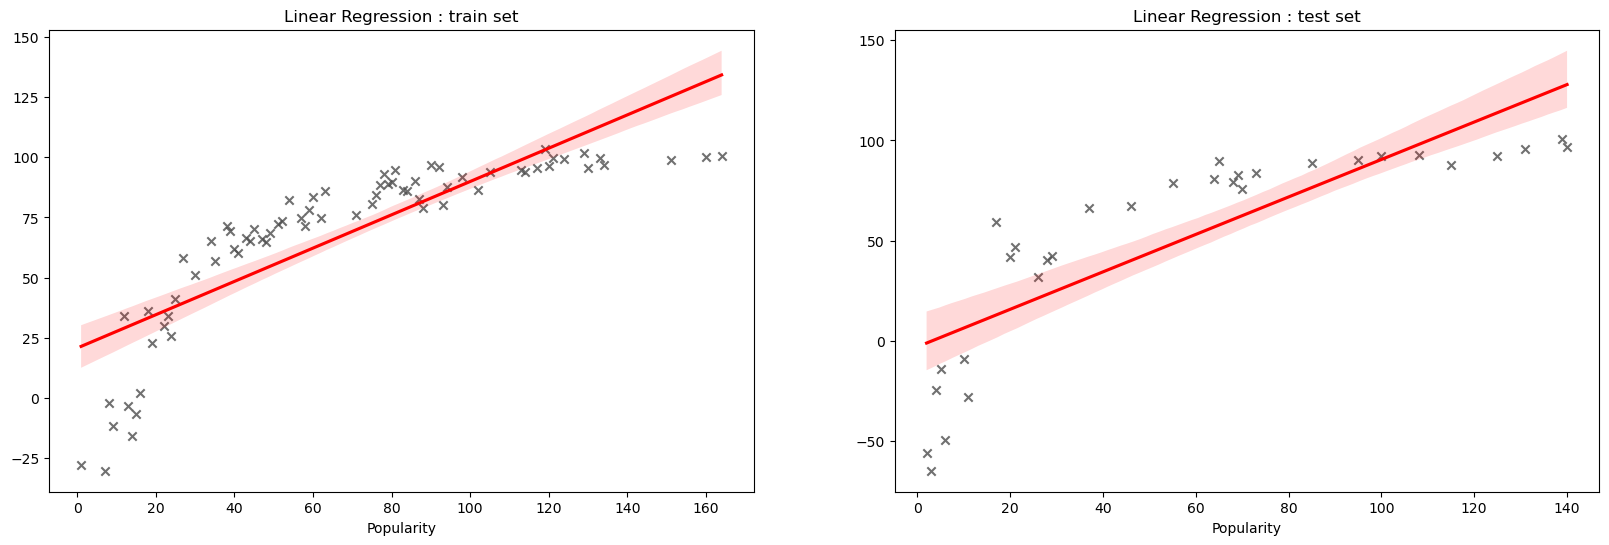

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))

ax1.set_title('Linear Regression : train set')
sns.regplot(x=y_train, y=train_pred, ci=85, marker="x", color=".3", line_kws=dict(color="r"), order=1, ax=ax1)

ax2.set_title('Linear Regression : test set')
sns.regplot(x=y_test, y=test_pred, ci=85, marker="x", color=".3", line_kws=dict(color="r"), order=1, ax=ax2)

plt.show()

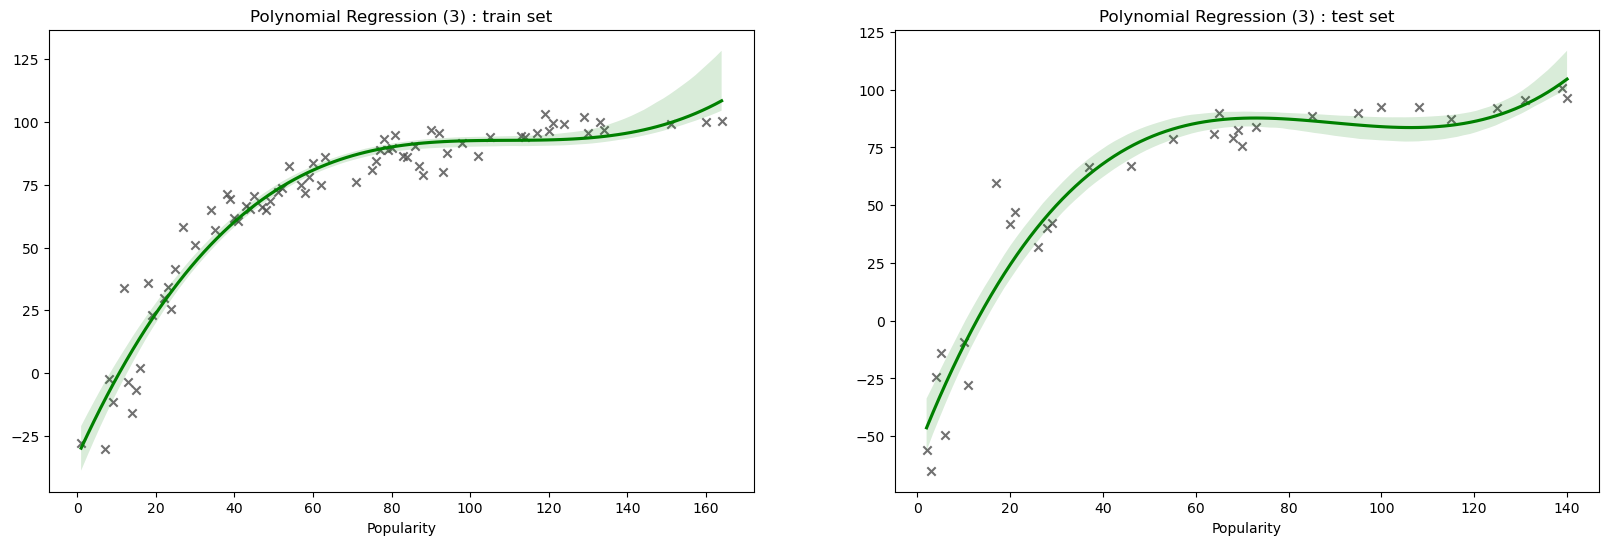

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))

ax1.set_title('Polynomial Regression (3) : train set')
sns.regplot(x=y_train, y=train_pred, ci=85, marker="x", color=".3", line_kws=dict(color="g"), order=3, ax=ax1)

ax2.set_title('Polynomial Regression (3) : test set')
sns.regplot(x=y_test, y=test_pred, ci=85, marker="x", color=".3", line_kws=dict(color="g"), order=3, ax=ax2)

plt.show()

### Polynomial Regression (3)

In [31]:
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly_2_train = poly_features.fit_transform(X_train)
X_poly_2_test = poly_features.fit_transform(X_test)

lr_poly2 = LinearRegression().fit(X_poly_2_train, y_train)


In [32]:
# MODEL METRICS

# Predictions
poly2_train_pred = lr_poly2.predict(X_poly_2_train)
poly2_test_pred = lr_poly2.predict(X_poly_2_test)

# Calculate MSES
train_mses = []
test_mses = []   
train_mses.append(mean_squared_error(y_train, poly2_train_pred))
test_mses.append(mean_squared_error(y_test, poly2_test_pred))

#Calculate other metrics
mae = mean_absolute_error(y_test, poly2_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, poly2_test_pred))
rmsle = np.log(np.sqrt(mean_squared_error(y_test, poly2_test_pred)))
r2 = r2_score(y_train, poly2_train_pred)
score = lr_poly2.score(X_poly_2_train, y_train)
intercept = lr_poly2.intercept_
coef = lr_poly2.coef_

# Print Metrics for Review
print('Model Metrics:', '\n')
print('Train MSE =', train_mses, '    Test MSE =', test_mses, '     MAE =', mae)
print("RMSE =", rmse, '     RMSLE =', rmsle)
print('Accuracy Score =', score, '      R2 Score =', r2, '\n') 



Model Metrics: 

Train MSE = [39.944024779029604]     Test MSE = [1197601327.5793958]      MAE = 7215.4618650908005
RMSE = 34606.37697851937      RMSLE = 10.451793249801154
Accuracy Score = 0.9764262088076493       R2 Score = 0.9764262088076493 



### Results from trying polynomial 3 on scaled and original target:|

#### X,y - Target Scaled - poly = 3:
        Accuracy Score = 0.999999792155457
        R2 Score = 0.999999792155457
        
#### X,y - Target not Scaled - poly = 3:
        Accuracy Score = 0.9764262088076493
        R2 Score = 0.9764262088076493

### BEST = Target not Scaled - poly = 3 (normalization method)
        Even though the scores are better with the target scaled, the scores are still great with the original target
        but the curve with the original target looks less likely to overfit or be affected by outliers.

### (7) K-nearest Neighbors (KNN)

In [33]:
# Define X,y with chosen scaled data

model_data = norm_data


X = model_data[X_features].drop(columns=['Popularity'])
y = data['Popularity']

C:\Users\dan\AppData\Local\Temp\ipykernel_28616\4134003617.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = model_data[X_features].drop(columns=['Popularity'])


In [34]:
# Train Test Split & confirm shapes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Shapes look correct

((72, 5), (31, 5), (72,), (31,))

In [35]:
# KNN Model (n_neighbors=3)

KNN2_model = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)


In [36]:
# KNN Model (n_neighbors=6)

KNN3_model = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)


In [37]:
# MODEL METRICS

# Predictions

KNN2_train_pred = KNN2_model.predict(X_train)
KNN2_test_pred = KNN2_model.predict(X_test)

KNN3_train_pred = KNN3_model.predict(X_train)
KNN3_test_pred = KNN3_model.predict(X_test)

# Calculate MSES
KNN2_train_mses = []
KNN2_test_mses = []
KNN2_train_mses.append(mean_squared_error(y_train, KNN2_train_pred))
KNN2_test_mses.append(mean_squared_error(y_test, KNN2_test_pred))

KNN3_train_mses = []
KNN3_test_mses = []
KNN3_train_mses.append(mean_squared_error(y_train, KNN3_train_pred))
KNN3_test_mses.append(mean_squared_error(y_test, KNN3_test_pred))

#Calculate other metrics
KNN2_mae = mean_absolute_error(y_test, KNN2_test_pred)
KNN2_rmse = np.sqrt(mean_squared_error(y_test, KNN2_test_pred))
KNN2_rmsle = np.log(np.sqrt(mean_squared_error(y_test, KNN2_test_pred)))
KNN2_r2 = r2_score(y_train, KNN2_train_pred)
KNN2_score = KNN2_model.score(X_train, y_train)

KNN3_mae = mean_absolute_error(y_test, KNN3_test_pred)
KNN3_rmse = np.sqrt(mean_squared_error(y_test, KNN3_test_pred))
KNN3_rmsle = np.log(np.sqrt(mean_squared_error(y_test, KNN3_test_pred)))
KNN3_r2 = r2_score(y_train, KNN3_train_pred)
KNN3_score = KNN3_model.score(X_train, y_train)

# Print Metrics for Review
print('Model Metrics:', '\n')
print('KNN Model 2 Neighbors:', '\n')
print('KNN 2 Train MSE =', KNN2_train_mses, '    KNN 2 Test MSE =', KNN2_test_mses, '     KNN 2 MAE =', KNN2_mae)
print("KNN 2 RMSE =", KNN2_rmse, '     KNN 2 RMSLE =', KNN2_rmsle)
print('KNN 2 Score =', KNN2_score, '      KNN 2 R2 Score =', KNN2_r2, '\n') 
print('KNN Model 3 Neighbors:', '\n')
print('KNN 3 Train MSE =', KNN3_train_mses, '    KNN 3 Test MSE =', KNN3_test_mses, '     KNN 3 MAE =', KNN3_mae)
print("KNN 3 RMSE =", KNN3_rmse, '     KNN 3 RMSLE =', KNN3_rmsle)
print('KNN 3 Score =', KNN3_score, '      KNN 3 R2 Score =', KNN3_r2, '\n') 



Model Metrics: 

KNN Model 2 Neighbors: 

KNN 2 Train MSE = [120.48611111111111]     KNN 2 Test MSE = [171.06451612903226]      KNN 2 MAE = 9.451612903225806
KNN 2 RMSE = 13.079163433837511      KNN 2 RMSLE = 2.571020386325992
KNN 2 Score = 0.4166666666666667       KNN 2 R2 Score = 0.9288926331128542 

KNN Model 3 Neighbors: 

KNN 3 Train MSE = [196.33333333333334]     KNN 3 Test MSE = [176.83870967741936]      KNN 3 MAE = 9.483870967741936
KNN 3 RMSE = 13.29807165259006      KNN 3 RMSLE = 2.5876190361887925
KNN 3 Score = 0.3194444444444444       KNN 3 R2 Score = 0.8841298284361161 



#### KNN Result: Best Model = KNN 2
    KNN 2 Score = 0.4166666666666667       KNN 2 R2 Score = 0.9288926331128542 

### (8) Support Vector Machine (SVM)

In [38]:
# Define X,y with chosen scaled data

model_data = data


X = model_data[X_features].drop(columns=['Popularity'])
y = data['Popularity']

In [39]:
# Train Test Split & confirm shapes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Shapes look correct

((72, 5), (31, 5), (72,), (31,))

In [40]:
# SVM Model

SVM_model = LinearSVC(max_iter=3000, random_state=42, C=.5).fit(X_train, y_train)


C:\Users\dan\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\dan\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [41]:
# MODEL METRICS

# Predictions
train_pred = SVM_model.predict(X_train)
test_pred = SVM_model.predict(X_test)

# Calculate MSES
train_mses = []
test_mses = []   
train_mses.append(mean_squared_error(y_train, train_pred))
test_mses.append(mean_squared_error(y_test, test_pred))

#Calculate other metrics
mae = mean_absolute_error(y_test, test_pred)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
rmsle = np.log(np.sqrt(mean_squared_error(y_test, test_pred)))
r2 = r2_score(y_train, train_pred)
score = SVM_model.score(X_train, y_train)
intercept = SVM_model.intercept_
coef = SVM_model.coef_

# Print Metrics for Review
print('Model Metrics:', '\n')
print('Train MSE =', train_mses, '    Test MSE =', test_mses, '     MAE =', mae, '\n')
print("RMSE =", rmse, '     RMSLE =', rmsle)
print('Score =', score, '      R2 Score =', r2, '\n') 


Model Metrics: 

Train MSE = [650.8055555555555]     Test MSE = [2429.0]      MAE = 38.54838709677419 

RMSE = 49.28488612140643      RMSLE = 3.8976174645010864
Score = 0.6944444444444444       R2 Score = 0.6159136602192649 



#### SVM Result:  Best Model:
    Score = 0.6944444444444444       R2 Score = 0.6159136602192649  

### (9) Neural Network

In [42]:
# Define X,y with chosen scaled data

model_data = norm_data


X = model_data[X_features].drop(columns=['Popularity'])
y = data['Popularity']


C:\Users\dan\AppData\Local\Temp\ipykernel_28616\3097058878.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = model_data[X_features].drop(columns=['Popularity'])


In [43]:
# Train Test Split & confirm shapes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Shapes look correct

((72, 5), (31, 5), (72,), (31,))

In [44]:
# Neural Network Model

NN_model = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)


C:\Users\dan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
# MODEL METRICS

# Predictions
train_pred = NN_model.predict(X_train)
test_pred = NN_model.predict(X_test)

# Calculate MSES
train_mses = []
test_mses = []   
train_mses.append(mean_squared_error(y_train, train_pred))
test_mses.append(mean_squared_error(y_test, test_pred))

#Calculate other metrics
mae = mean_absolute_error(y_test, test_pred)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
rmsle = np.log(np.sqrt(mean_squared_error(y_test, test_pred)))
r2 = r2_score(y_train, train_pred)
score = NN_model.score(X_train, y_train)

# Print Metrics for Review
print('Model Metrics:', '\n')
print('Train MSE =', train_mses, '    Test MSE =', test_mses, '     MAE =', mae)
print("RMSE =", rmse, '     RMSLE =', rmsle)
print('Score =', score, '      R2 Score =', r2, '\n') 


Model Metrics: 

Train MSE = [822.5833333333334]     Test MSE = [691.2258064516129]      MAE = 16.451612903225808
RMSE = 26.29117354648919      RMSLE = 3.2692332762578524
Score = 0.3055555555555556       R2 Score = 0.5145354569154932 



#### NN Best Model: Using standardization scaler on features
    Score = 0.9861111111111112       R2 Score = 0.9551142431038605
